In [ ]:
import sys
import numpy as np
import pandas as pd
import imageio
from imageio import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import concatenate
# from keras.layers.core import Lambda, Flatten, Dense
from tensorflow.keras.layers import (
    Conv2D, ZeroPadding2D, Activation, Input, concatenate,
    BatchNormalization, MaxPooling2D, Concatenate,
    Lambda, Flatten, Dense
)
from keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

### Please give below paths as per the paths in your system

This code appears to be importing
various libraries and modules for a
deep learning project, likely related
to computer vision tasks. Here is a
general overview:
1. Libraries and Modules:
- `sys`, `numpy`, `pandas`:
General-purpose libraries for
system-level operations, numerical
computations, and data
manipulation.
- `imageio`: A library for reading
and writing images.
- `pickle`: A module for serializing
and deserializing Python objects.
- `os`: Provides a way of interacting
with the operating system.
- `matplotlib.pyplot`: Used for
creating visualizations and plots.
- `cv2`: OpenCV library for
computer vision tasks.
- `time`: Provides functions for
working with time.
- `tensorflow` and `keras`: Deep
learning frameworks for building and
training neural networks.
2. Neural Network Components:
- The code imports various layers
and components from Keras and
TensorFlow for building a neural
network. These include convolutional
layers, activation functions, batch
normalization, max-pooling layers,
etc.
3. Model Architecture:
- The code defines a neural
network model using Keras. The
architecture includes convolutional
layers, batch normalization,
max-pooling, and concatenation of
features.
4. Other Components:
- The code includes some
elements from the ImageNet model,
such as `ZeroPadding2D`, `Conv2D`,
and `Flatten`.
- It uses the Adam optimizer for
training the model.
5. Data Handling:
- The code uses `shuffle` from
scikit-learn to shuffle data.
6. Random Number Generation:
- `numpy.random as rng` is
imported for random number
generation.
It's important to note that without the
specific implementation of the neural
network architecture and the details
of the training process, it's
challenging to provide more specific
information about the intended
functionality of this code.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_folder = "/content/drive/MyDrive/images_background"
val_folder = '/content/drive/MyDrive/images_evaluation'
save_path = '/content/drive/MyDrive/Data_save'

In [ ]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

This code seems to be related to
loading images for a few-shot
learning task using a dataset
organized by alphabets and letters.
Here is a general overview:
1. Mounting Google Drive:
- The code uses Google Colab's
`drive` module to mount the Google
Drive. It allows access to files stored
on Google Drive.
2. Data Paths:
- `train_folder`, `val_folder`: Paths
to the training and validation image
folders on Google Drive.
- `save_path`: Path where the data
will be saved.
3. Function `loadimgs`:
- This function is designed to load
images from the specified directory
structure.
- It takes a path and an optional
parameter `n`.
- `X`: A list where each element is
a stack of images for a particular
category.
- `y`: A list containing labels
corresponding to the categories.
- `cat_dict`: A dictionary that maps
labels to tuples of alphabet and
letter.
- `lang_dict`: A dictionary that
maps each alphabet to a tuple
containing the range of labels
corresponding to that alphabet.
- `curr_y`: Current label value,
initialized with `n`.
4. Loading Process:
- The code iterates through each
alphabet and then through each
letter within that alphabet.
- For each letter, it loads images
and appends them to the `X` list, and
assigns corresponding labels to `y`.
- It handles edge cases, such as a
last category within an alphabet,
where a ValueError may occur during
stacking.
- The function returns three values:
`X` (stacked images), `y` (labels),
and `lang_dict` (dictionary mapping
alphabets to label ranges).
5. Data Representation:
- `X`: Images are stacked, forming
a 3D array where the first dimension
corresponds to different categories
(alphabets and letters), and the
second and third dimensions
correspond to image dimensions.
- `y`: Labels are stacked to form a
2D array.
- `lang_dict`: A dictionary providing
information about the range of labels
for each alphabet.
6. Note:
- The code assumes that images
are organized in a directory structure
where there are subdirectories for
each alphabet, and within each
alphabet subdirectory, there are
subdirectories for each letter
containing the corresponding
images.


### Loading the train images into tensors

In [ ]:
X,y,c=loadimgs(train_folder)

loading alphabet: Tagalog


<ipython-input-4-b88039de8434>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)


loading alphabet: Sanskrit
loading alphabet: Latin
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Korean
loading alphabet: N_Ko
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Tifinagh
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Gujarati
loading alphabet: Futurama
loading alphabet: Japanese_(hiragana)
loading alphabet: Greek
loading alphabet: Japanese_(katakana)
loading alphabet: Grantha
loading alphabet: Hebrew
loading alphabet: Early_Aramaic
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Cyrillic
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Balinese
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Braille
loading alphabet: Arcadian
loading alphabet: Bengali
loading alphabet: Burmese_(Myanmar)
loading alphabet: Armenian


### Saving the train tensors on disk

In [ ]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

### Loading the validation images into tensors

In [ ]:
Xval,yval,cval=loadimgs(val_folder)

loading alphabet: Sylheti


<ipython-input-4-b88039de8434>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)


loading alphabet: Tibetan
loading alphabet: ULOG
loading alphabet: Syriac_(Serto)
loading alphabet: Tengwar
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Oriya
loading alphabet: Malayalam
loading alphabet: Mongolian
loading alphabet: Manipuri
loading alphabet: Gurmukhi
loading alphabet: Ge_ez
loading alphabet: Keble
loading alphabet: Glagolitic
loading alphabet: Kannada
loading alphabet: Atemayar_Qelisayer
loading alphabet: Aurek-Besh
loading alphabet: Atlantean
loading alphabet: Avesta
loading alphabet: Angelic


### Saving the validation tensors on disk

In [ ]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

In [ ]:
# del X, y ,c ,Xval, yval, cval

In [ ]:
def initialize_weights(shape, dtype=None):
  # dtype not name
#     """
#         The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
#         suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
#     """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)


This code appears to perform the
following tasks:
1. Loading and Saving Training Data:
- Calls the `loadimgs` function with
the `train_folder` path, which loads
images from the training dataset.
- The returned values `(X, c)` are
then saved to a pickle file named
"train.pickle" in the specified
`save_path` using the `pickle.dump`
function.
2. Loading and Saving Validation
Data:
- Calls the `loadimgs` function with
the `val_folder` path, which loads
images from the validation dataset.
- The returned values `(Xval, cval)`
are then saved to a pickle file named
"val.pickle" in the specified
`save_path` using the `pickle.dump`
function.
3. Weights Initialization Function:
- Defines a function named
`initialize_weights` that takes a
`shape` argument and an optional
`dtype` argument.
- The function is commented with a
reference to a paper suggesting
initializing CNN layer weights with a
mean of 0.0 and a standard deviation
of 0.01.
- The function returns randomly
generated weights using a normal
distribution with a mean of 0.0 and a
standard deviation of 1e-2.
4. Note:
- The code saves the loaded data
(images and label information) in
pickle files. Pickle is a serialization
format in Python that allows saving
and loading complex Python objects,
such as lists and dictionaries.
- The weights initialization function
is commented, and it seems like
there might be some discrepancy in
the comments regarding the mean
and standard deviation values. The
actual implementation generates
random weights with a mean of 0.0
and a standard deviation of 1e-2.



In [ ]:
def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [ ]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    # return the model
    return siamese_net

In [ ]:
model = get_siamese_model((105, 105, 1))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 105, 105, 1)]        0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 105, 105, 1)]        0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 4096)                 3894764   ['input_9[0][0]',             
                                                          8          'input_10[0][0]']            
                                                                                                  
 lambda_1 (Lambda)           (None, 4096)                 0         ['sequential_4[0][0]',  

This code defines a Siamese Neural
Network model for image similarity,
following the architecture proposed
in a specific paper. Here's a
breakdown of the code:
1. Bias Initialization Function:
- Defines a function `initialize_bias`
to initialize the bias of a neural
network layer.
- The initialization is based on
suggestions from a referenced
paper, setting the mean to 0.5 and
the standard deviation to 0.01.
2. Siamese Model Architecture:
- Defines a function
`get_siamese_model` that constructs
a Siamese Neural Network.
- The function takes `input_shape`
as an argument, representing the
shape of the input images.
- Constructs two input tensors for
the left and right images.
- Uses a Convolutional Neural
Network (CNN) with multiple
convolutional and max-pooling
layers:
- First convolutional layer with 64
filters of size (10, 10) and ReLU
activation.
- Max-pooling layer.
- Second convolutional layer with
128 filters of size (7, 7) and ReLU
activation.
- Max-pooling layer.
- Third convolutional layer with
128 filters of size (4, 4) and ReLU
activation.
- Max-pooling layer.
- Fourth convolutional layer with
256 filters of size (4, 4) and ReLU
activation.
- Flatten layer.
- Fully connected layer with 4096
units and sigmoid activation.
- Generates encodings (feature
vectors) for the left and right input
images using the shared CNN.
- Computes the absolute difference
between the encodings using a
Lambda layer.
- Adds a dense layer with a single
sigmoid unit to predict the similarity
score between the two images.
- Constructs a Siamese network
model using the defined layers and
connections.
- Returns the constructed Siamese
network model.
3. Create and Summarize the Model:
- Calls `get_siamese_model` to
create a Siamese network model
with input shape (105, 105, 1).
- Prints a summary of the model
architecture using
`model.summary()`.
4. Note:
- This Siamese network is
designed for image similarity tasks,
where it takes pairs of images as
input and predicts whether they
belong to the same class or not.
- The convolutional layers learn
hierarchical features from the input
images, and the final sigmoid layer
produces a similarity score.


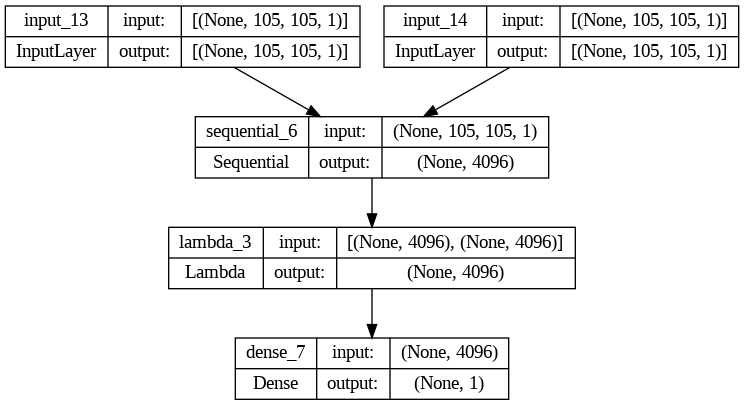

In [ ]:
# from IPython.display import Image
# Image(retina=True, filename='model.png')
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model
model = get_siamese_model((105, 105, 1))

# Generate the model summary plot
plot_path = 'model.png'
plot_model(model, to_file=plot_path, show_shapes=True, show_layer_names=True)

# Display the saved image
Image(retina=True, filename=plot_path)

In [ ]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

### Loading the train tensors

In [ ]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)

print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Tagalog', 'Sanskrit', 'Latin', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Syriac_(Estrangelo)', 'Korean', 'N_Ko', 'Malay_(Jawi_-_Arabic)', 'Tifinagh', 'Mkhedruli_(Georgian)', 'Gujarati', 'Futurama', 'Japanese_(hiragana)', 'Greek', 'Japanese_(katakana)', 'Grantha', 'Hebrew', 'Early_Aramaic', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Cyrillic', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Anglo-Saxon_Futhorc', 'Balinese', 'Asomtavruli_(Georgian)', 'Alphabet_of_the_Magi', 'Braille', 'Arcadian', 'Bengali', 'Burmese_(Myanmar)', 'Armenian']


In [ ]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Sylheti', 'Tibetan', 'ULOG', 'Syriac_(Serto)', 'Tengwar', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Malayalam', 'Mongolian', 'Manipuri', 'Gurmukhi', 'Ge_ez', 'Keble', 'Glagolitic', 'Kannada', 'Atemayar_Qelisayer', 'Aurek-Besh', 'Atlantean', 'Avesta', 'Angelic']


In [ ]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)

    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]

    # initialize vector for the targets
    targets=np.zeros((batch_size,))

    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)

        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes

        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)

    return pairs, targets

This code performs the following
tasks:
1. Plotting Model Summary:
- Imports necessary libraries for
plotting.
- Creates a Siamese neural
network model using the
`get_siamese_model` function.
- Generates a model summary plot
using the `plot_model` function from
Keras.
- Saves the plot to a file named
'model.png'.
2. Displaying Model Summary:
- Uses IPython's `Image` module to
display the saved 'model.png' image
in the notebook.
3. Model Compilation:
- Configures the model for training
by specifying the loss function and
optimizer.
- Uses the Adam optimizer with a
learning rate of 0.00006.
- The binary cross-entropy loss is
used, which is common for binary
classification tasks.
4. Loading Training and Validation
Data:
- Loads training and validation data
from pickle files ('train.pickle' and
'val.pickle') stored in the `save_path`.
5. Printing Information about Training
and Validation Alphabets:
- Prints information about the
alphabets present in the training and
validation datasets.
6. Batch Generation Function
(`get_batch`):
- Defines a function `get_batch` to
generate batches of pairs of images
for training the Siamese network.
- The function takes a `batch_size`
and a flag `s` indicating whether to
generate batches for training or
validation.
- Randomly samples several
classes to use in the batch.
- Initializes arrays for the input
image batch (`pairs`) and the target
values (`targets`).
- Assigns targets such that the
second half of the batch has the
same class (target = 1) and the first
half has a different class (target = 0).
- Randomly selects images from
the chosen classes for both elements
of the pair.
- Returns the pairs of images and
their corresponding targets.
Overall, this code is setting up the
Siamese network model, visualizing
its architecture, compiling it for
training, and preparing data loading
and batch generation functions for
the training process.


In [ ]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [ ]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

This code defines two functions for
generating batches of data for
training and testing a Siamese
network in a one-shot learning
setting:
1. `generate` Function (Data
Generator):
- Takes a `batch_size` and a flag
`s` (defaulted to "train") indicating
whether to generate batches for
training or validation.
- It continuously yields batches of
pairs and targets using the
`get_batch` function defined earlier.
- This function is designed to be
used with `model.fit_generator`
during training.
2. `make_oneshot_task` Function:
- Takes parameters `N` (number of
classes for one-shot task), `s` (flag
for training or validation), and an
optional `language` parameter.
- Selects a random true category
and two random examples for the
task.
- If a language is specified, it
selects characters only from that
language. Otherwise, it randomly
selects characters from the entire
dataset.
- Constructs a test image by
repeating one of the examples from
the true category N times.
- Creates a support set by
selecting N examples from the
chosen categories (excluding the
true category) and replacing one of
them with another example from the
true category.
- Shuffles the targets, test image,
and support set.
- Returns pairs (test image, support
set) and targets for the one-shot
task.
These functions are useful for
generating batches of data for
training the Siamese network and
creating one-shot tasks for
evaluating the model's performance
in a few-shot learning scenario. The
`generate` function is designed for
continuous training data generation,
while the `make_oneshot_task`
function is designed for creating
tasks used in one-shot learning
evaluation.

In [ ]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [ ]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [ ]:
model_path = './weights/'
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss))
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 37ms/step
Got an average of 4.4% 20 way one-shot learning accuracy 


 ------------- 

Time for 16400 iterations: 60.28764089345932 mins
Train Loss: 0.7056096196174622
Evaluating model on 250 random 20 way one-shot learning tasks ... 

1/1 [==============================] - 0s 21ms/step
Got an average of 4.4% 20 way one-shot learning accuracy 


 ------------- 

Time for 16600 iterations: 61.006326683362325 mins
Train Loss: 0.7026960253715515
Evaluating model on 250 random 20 way one-shot learning tasks ... 

1/1 [==============================] - 0s 19ms/step
Got an average of 8.0% 20 way one-shot learning accuracy 


 ------------- 

Time for 16800 iterations: 61.739817190170285 mins
Train Loss: 0.7004169821739197
Evaluating model on 250 random 20 way one-shot learning tasks ... 

1/1 [==============================] - 0s 35ms/step
Got an average of 5.2% 20 way one-shot learning accuracy 


 

This code implements a training loop
for a Siamese neural network and
periodically evaluates its
performance on one-shot learning
tasks. Here's a general overview:
1. `test_oneshot` Function:
- Evaluates the model's accuracy
on N-way one-shot learning tasks
over k iterations.
- Calls `make_oneshot_task` to
create one-shot tasks and uses the
model to predict the outcomes.
- Tracks the number of correctly
predicted tasks.
- Returns the percentage of
correctly predicted tasks.
2. Hyperparameters and
Configuration:
- `evaluate_every`: Interval for
evaluating the model on one-shot
tasks during training.
- `batch_size`: Size of the training
batch.
- `n_iter`: Number of training
iterations.
- `N_way`: Number of classes for
testing one-shot tasks.
- `n_val`: Number of one-shot tasks
to validate on during evaluation.
- `best`: Variable to track the best
accuracy achieved during evaluation.
- `model_path`: Path to save the
trained model weights.
3. Training Loop:
- Iterates through the training
process for a specified number of
iterations (`n_iter`).
- Retrieves a batch of inputs and
targets using the `get_batch`
function.
- Trains the model on the current
batch using `model.train_on_batch`.
- Periodically evaluates the model
on one-shot tasks (`test_oneshot`)
and prints the training loss.
- Saves the model weights if the
validation accuracy on one-shot
tasks improves.
- Tracks and prints the time taken
for each iteration.
4. Note:
- The training loop is designed for
training a Siamese neural network on
one-shot learning tasks.
- The model is saved periodically,
and the best model is determined
based on the performance in
one-shot tasks during evaluation.
- This type of training loop is
common in few-shot learning
scenarios, where the model needs to
generalize well to new classes with
limited examples.

### Load model weights

In [ ]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

### Testing

### Baseline model based on Nearest Neighbors using Euclidean distance (L2 distance)

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [ ]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0

    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [ ]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [ ]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

1/1 [==============================] - 0s 28ms/step
Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 50 random 1 way one-shot learning tasks ... 

1/1 [==============================] - 0s 18ms/step
Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 3 way one-shot learning tasks ... 



<ipython-input-56-0e6416d38168>:6: RuntimeWarning: invalid value encountered in sqrt
  L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))


1/1 [==============================] - 0s 18ms/step
Got an average of 32.0% 3 way one-shot learning accuracy 

Evaluating model on 50 random 3 way one-shot learning tasks ... 

1/1 [==============================] - 0s 18ms/step
Got an average of 44.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 3 way one-shot learning tasks ...
NN Accuracy =  40.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 5 way one-shot learning tasks ... 

1/1 [==============================] - 0s 32ms/step
Got an average of 24.0% 5 way one-shot learning accuracy 

Evaluating model on 50 random 5 way one-shot learning tasks ... 

1/1 [==============================] - 0s 22ms/step
Got an average of 30.0% 5 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 5 way one-shot learning tasks ...
NN Accuracy =  22.0
------------------------------------------------------

This code evaluates the performance
of a trained Siamese neural network
model on one-shot learning tasks
and compares it to a nearest
neighbor approach. Here's a general
overview:
1. Loading Model Weights:
- Loads the weights of a
pre-trained Siamese neural network
model using `model.load_weights`.
2. Nearest Neighbor Correct
Function
(`nearest_neighbour_correct`):
- Takes pairs of images and their
corresponding targets.
- Computes L2 distances between
pairs of images.
- Returns 1 if the nearest neighbor
approach gets the correct answer for
a one-shot task, otherwise returns 0.
3. Nearest Neighbor Accuracy
Function (`test_nn_accuracy`):
- Takes the number of ways
(`N_ways`) and the number of trials
(`n_trials`).
- Evaluates the nearest neighbor
approach on unique one-shot
learning tasks.
- Calls `make_oneshot_task` to
create tasks and
`nearest_neighbour_correct` to
determine correctness.
- Returns the accuracy of the
nearest neighbor approach.
4. Testing Different Ways:
- Defines a range of `ways`
(number of classes for testing
one-shot tasks).
- Iterates through each `N` in the
`ways` range.
- For each `N`, evaluates the
Siamese network's accuracy on
one-shot tasks for both training and
validation sets using `test_oneshot`.
- Also, evaluates the nearest
neighbor accuracy using
`test_nn_accuracy`.
- Prints the nearest neighbor
accuracy.
5. Note:
- The code tests the Siamese
neural network model on one-shot
learning tasks for various numbers of
ways (`N`).
- It compares the performance of
the Siamese network to a nearest
neighbor approach based on L2
distances between pairs of images.
- The results for Siamese network
accuracy and nearest neighbor
accuracy are printed for each `N`.


### Save the accuracies on disk

In [ ]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

### Load the accuracies from disk

In [ ]:
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

### Below two functions are used for visualizing test image and support set

In [ ]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [ ]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

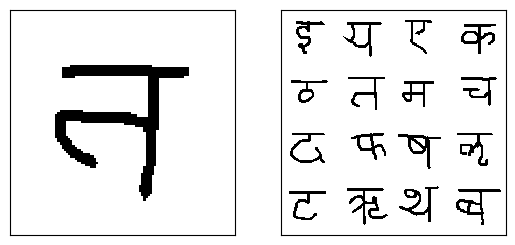

In [ ]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16,"train","Sanskrit")
plot_oneshot_task(pairs)

This code involves saving and
loading accuracies, as well as
defining functions for visualizing
concatenated images of one-shot
learning tasks.
1. Saving Accuracies to a Pickle File:
- Uses `pickle.dump` to save
accuracy data (validation accuracies,
training accuracies, and nearest
neighbor accuracies) to a pickle file
named "accuracies.pickle" in the
specified `save_path`.
2. Loading Accuracies from a Pickle
File:
- Uses `pickle.load` to load
accuracy data from the saved pickle
file "accuracies.pickle" into variables
`val_accs`, `train_accs`, and
`nn_accs`.
3. Concatenating Images
(`concat_images` Function):
- Takes a 4D array `X` representing
a batch of images.
- Reshapes and concatenates the
images into a big matrix for plotting
purposes.
- The function creates a grid of
images where the number of rows
and columns is approximately the
square root of the number of images.
4. Plotting One-shot Task Images
(`plot_oneshot_task` Function):
- Takes pairs of images (`pairs`)
from a one-shot learning task.
- Plots the test image and the
support set as two subplots using
`matshow`.
- The support set images are
concatenated using the
`concat_images` function for better
visualization.
- Removes axis labels for better
clarity.
- Displays the plotted images.
5. Example Visualization:
- Generates a one-shot task
(`pairs, targets`) for the training set in
the Sanskrit language.
- Calls the `plot_oneshot_task`
function to visualize the test image
and the support set.
Overall, this code is concerned with
saving and loading accuracy data
and defining visualization functions
for one-shot learning tasks, providing
a way to inspect the model's
performance and the generated
tasks visually.

### Resuts

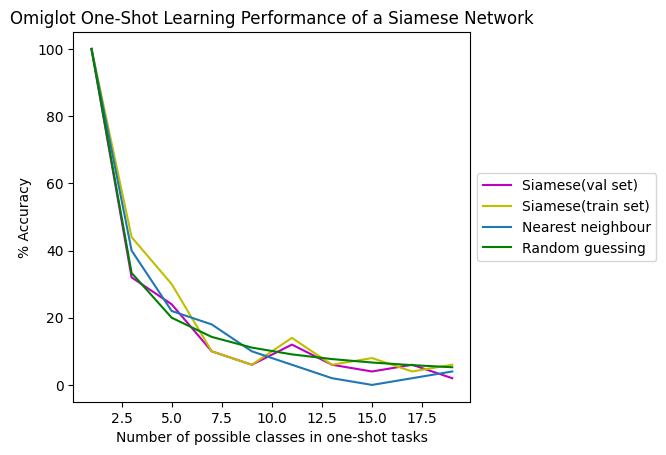

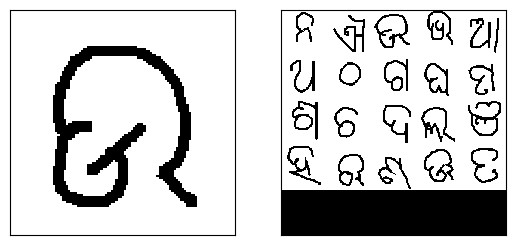

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

plot_oneshot_task(inputs)

This code uses matplotlib to create
plots showing the performance of the
Siamese network and a nearest
neighbor approach on one-shot
learning tasks. Additionally, it plots
an example of a one-shot task.
1. Performance Plotting:
- Creates a subplot with a single
plot (`ax`) using `plt.subplots(1)`.
- Plots the Siamese network
accuracy on the validation and
training sets (`val_accs` and
`train_accs`) for different numbers of
possible classes (`ways`).
- Also plots the accuracy of the
nearest neighbor approach
(`nn_accs`).
- Adds a line representing random
guessing (`100.0/ways`) for
reference.
- Labels the x-axis as "Number of
possible classes in one-shot tasks"
and the y-axis as "% Accuracy".
- Sets the title of the plot as
"Omiglot One-Shot Learning
Performance of a Siamese Network".
- Adjusts the legend position and
displays the plot.
2. Example One-shot Task Plotting:
- Generates a one-shot task
(`inputs, targets`) for the validation
set in the Oriya language.
- Calls the `plot_oneshot_task`
function to visualize the test image
and the support set.
These plots provide a visual
representation of the performance of
the Siamese network on one-shot
learning tasks with varying numbers
of possible classes. The example
one-shot task plot demonstrates how
the test image and support set are
displayed